<a href="https://colab.research.google.com/github/rahu2004/intelproject-2025/blob/main/intel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download(
'andrewmvd/lung-and-colon-cancer-histopathological-images'
)

print("Dataset path:", andrewmvd_lung_and_colon_cancer_histopathological_images_path)
print('Data source import complete.')

Dataset path: /kaggle/input/lung-and-colon-cancer-histopathological-images
Data source import complete.


In [ ]:
!pip install pytorch-msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pytorch_msssim import ssim


In [ ]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pytorch_msssim import ssim


class HistologyImageDataset(Dataset):
    def __init__(self, base_path, image_size=256): # Reduced image size
        colon_aca_path_jpg = os.path.join(base_path, "lung_colon_image_set", "colon_image_sets", "colon_aca", "*.jpg")
        colon_aca_path_jpeg = os.path.join(base_path, "lung_colon_image_set", "colon_image_sets", "colon_aca", "*.jpeg")
        colon_n_path_jpg = os.path.join(base_path, "lung_colon_image_set", "colon_image_sets", "colon_n", "*.jpg")
        colon_n_path_jpeg = os.path.join(base_path, "lung_colon_image_set", "colon_image_sets", "colon_n", "*.jpeg")
        lung_aca_path_jpg = os.path.join(base_path, "lung_colon_image_set", "lung_image_sets", "lung_aca", "*.jpg")
        lung_aca_path_jpeg = os.path.join(base_path, "lung_colon_image_set", "lung_image_sets", "lung_aca", "*.jpeg")
        lung_n_path_jpg = os.path.join(base_path, "lung_colon_image_set", "lung_image_sets", "lung_n", "*.jpg")
        lung_n_path_jpeg = os.path.join(base_path, "lung_colon_image_set", "lung_image_sets", "lung_n", "*.jpeg")


        self.image_paths = glob.glob(colon_aca_path_jpg) + glob.glob(colon_aca_path_jpeg) + \
                           glob.glob(colon_n_path_jpg) + glob.glob(colon_n_path_jpeg) + \
                           glob.glob(lung_aca_path_jpg) + glob.glob(lung_aca_path_jpeg) + \
                           glob.glob(lung_n_path_jpg) + glob.glob(lung_n_path_jpeg)


        print(f"Colon ACA glob pattern (*.jpg): {colon_aca_path_jpg}")
        print(f"Colon ACA glob pattern (*.jpeg): {colon_aca_path_jpeg}")
        print(f"Colon N glob pattern (*.jpg): {colon_n_path_jpg}")
        print(f"Colon N glob pattern (*.jpeg): {colon_n_path_jpeg}")
        print(f"Lung ACA glob pattern (*.jpg): {lung_aca_path_jpg}")
        print(f"Lung ACA glob pattern (*.jpeg): {lung_aca_path_jpeg}")
        print(f"Lung N glob pattern (*.jpg): {lung_n_path_jpg}")
        print(f"Lung N glob pattern (*.jpeg): {lung_n_path_jpeg}")
        print(f"Found {len(self.image_paths)} images in total.")


        self.hr_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((image_size // 2, image_size // 2)),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        self.blur = transforms.GaussianBlur(kernel_size=5)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        hr_img = self.hr_transform(img)
        lr_img = self.lr_transform(img)
        if random.random() > 0.5:
            lr_img = self.blur(lr_img)
        return lr_img, hr_img

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
    def forward(self, x):
        return x + self.conv(x)

class TeacherSharpNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding=1),
            *[ResBlock(128) for _ in range(6)]
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            # Removed PixelShuffle(2)
            nn.Conv2d(64, 3, 3, padding=1) # Adjusted input channels to match previous layer output
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

class StudentSharpNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            ResBlock(64),
            ResBlock(64)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 3, 3, padding=1)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def ssim_loss(pred, target):
    return 1 - ssim(pred, target, data_range=1.0, size_average=True)

def distillation_loss(student_out, teacher_out):
    return F.mse_loss(student_out, teacher_out)

In [ ]:
base_path = andrewmvd_lung_and_colon_cancer_histopathological_images_path
dataset = HistologyImageDataset(base_path)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

Colon ACA glob pattern (*.jpg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/*.jpg
Colon ACA glob pattern (*.jpeg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/*.jpeg
Colon N glob pattern (*.jpg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/*.jpg
Colon N glob pattern (*.jpeg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/*.jpeg
Lung ACA glob pattern (*.jpg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/*.jpg
Lung ACA glob pattern (*.jpeg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/*.jpeg
Lung N glob pattern (*.jpg): /kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher = TeacherSharpNet().to(device)
student = StudentSharpNet().to(device)
teacher.eval()

optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
l1_loss = nn.L1Loss()
alpha, beta, gamma = 0.4, 0.3, 0.3

for epoch in range(1): # Increase for longer training
    for i, (lr_img, hr_img) in enumerate(train_loader):
        lr_img, hr_img = lr_img.to(device), hr_img.to(device)
        with torch.no_grad():
            teacher_out = teacher(lr_img)
        student_out = student(lr_img)

        loss = (alpha * l1_loss(student_out, hr_img) +
                beta * ssim_loss(student_out, hr_img) +
                gamma * distillation_loss(student_out, teacher_out))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"[Epoch {epoch+1}] Batch {i}/{len(train_loader)} Loss: {loss.item():.4f}")

[Epoch 1] Batch 0/2500 Loss: 0.6153
[Epoch 1] Batch 10/2500 Loss: 0.3193
[Epoch 1] Batch 20/2500 Loss: 0.2707
[Epoch 1] Batch 30/2500 Loss: 0.2302
[Epoch 1] Batch 40/2500 Loss: 0.2027
[Epoch 1] Batch 50/2500 Loss: 0.2369
[Epoch 1] Batch 60/2500 Loss: 0.2242
[Epoch 1] Batch 70/2500 Loss: 0.2153
[Epoch 1] Batch 80/2500 Loss: 0.2124
[Epoch 1] Batch 90/2500 Loss: 0.2362
[Epoch 1] Batch 100/2500 Loss: 0.2024
[Epoch 1] Batch 110/2500 Loss: 0.2210
[Epoch 1] Batch 120/2500 Loss: 0.1897
[Epoch 1] Batch 130/2500 Loss: 0.1937
[Epoch 1] Batch 140/2500 Loss: 0.2125
[Epoch 1] Batch 150/2500 Loss: 0.2082
[Epoch 1] Batch 160/2500 Loss: 0.1876
[Epoch 1] Batch 170/2500 Loss: 0.1953
[Epoch 1] Batch 180/2500 Loss: 0.1786
[Epoch 1] Batch 190/2500 Loss: 0.1760
[Epoch 1] Batch 200/2500 Loss: 0.1812


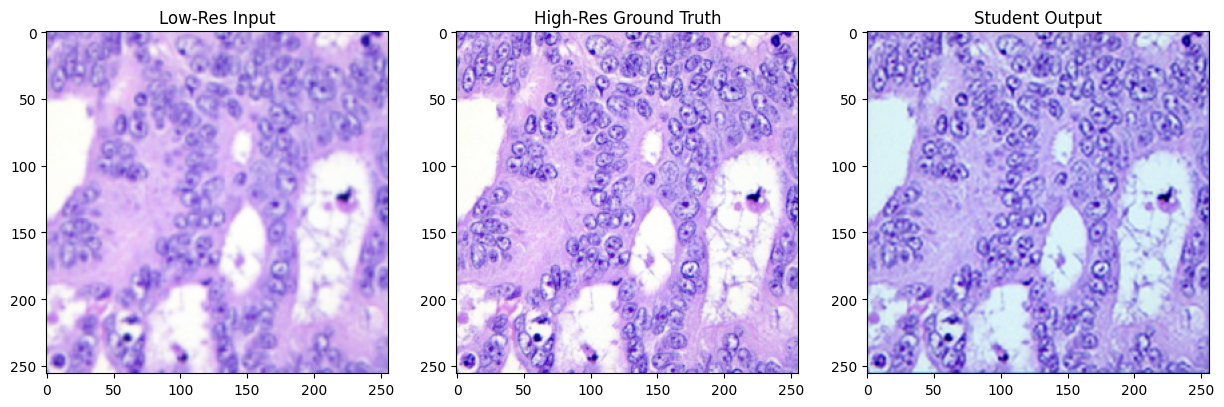

In [ ]:
lr_img, hr_img = dataset[0]
lr_img = lr_img.unsqueeze(0).to(device)

with torch.no_grad():
    sr_img = student(lr_img).squeeze().cpu()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(lr_img.squeeze().permute(1, 2, 0).cpu())
plt.title("Low-Res Input")

plt.subplot(1, 3, 2)
plt.imshow(hr_img.permute(1, 2, 0))
plt.title("High-Res Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(sr_img.permute(1, 2, 0))
plt.title("Student Output")
plt.show()

In [ ]:
student.eval()
ssim_scores = [] # List to store SSIM scores
with torch.no_grad():
    # Calculate SSIM for a limited number of batches
    num_batches_to_evaluate = 10
    for i, (lr_img, hr_img) in enumerate(train_loader):
        if i >= num_batches_to_evaluate:
            break
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)
        # Assuming 'student' is the model you want to evaluate
        sr_img = student(lr_img)
        ssim_val = ssim(sr_img, hr_img, data_range=1.0, size_average=True)
        ssim_scores.append(ssim_val.item()) # Append SSIM score to the list
        print(f"SSIM for batch {i+1}: {ssim_val.item():.4f}")

if ssim_scores: # Check if any scores were recorded
    average_ssim = sum(ssim_scores) / len(ssim_scores)
    print(f"\nAverage SSIM over {len(ssim_scores)} batches: {average_ssim:.4f}")
else:
    print("No SSIM scores were calculated.")

SSIM for batch 1: 0.8764
SSIM for batch 2: 0.9128
SSIM for batch 3: 0.9467
SSIM for batch 4: 0.9184
SSIM for batch 5: 0.9471
SSIM for batch 6: 0.9354
SSIM for batch 7: 0.9015
SSIM for batch 8: 0.9442
SSIM for batch 9: 0.9443
SSIM for batch 10: 0.9234

Average SSIM over 10 batches: 0.9250


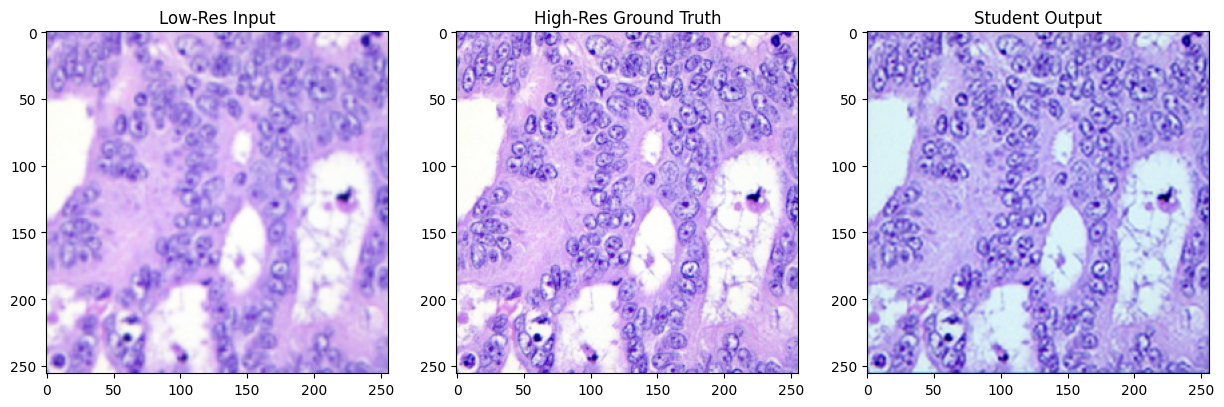

In [ ]:
lr_img, hr_img = dataset[0]
lr_img = lr_img.unsqueeze(0).to(device)

with torch.no_grad():
    sr_img = student(lr_img).squeeze().cpu()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(lr_img.squeeze().permute(1, 2, 0).cpu())
plt.title("Low-Res Input")

plt.subplot(1, 3, 2)
plt.imshow(hr_img.permute(1, 2, 0))
plt.title("High-Res Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(sr_img.permute(1, 2, 0))
plt.title("Student Output")
plt.show()